# PROCESSING X_TRAIN

### Loading Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from utils import *

### Loading dataframe

In [2]:
df = pd.read_csv('../X_train_Hi5.csv')

/tmp/ipykernel_14229/1897221112.py:1: DtypeWarning: Columns (108,110,111,115,117,118,122,124,125) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../X_train_Hi5.csv')


# Processing Dataframe

In [3]:
# Processing for piezo datas
df = df[df['piezo_qualification'] != 'Incorrecte']

df.loc[:, 'piezo_continuity_code'] = df['piezo_continuity_code'] - 1

df.loc[:, 'days_since_2020'] = df['piezo_measurement_date'].apply(days_since_start_of_2020)

The next cell fill NaN values with the median

In [4]:
missing_columns = df.columns[df.isna().sum() > 0].tolist()
for var in missing_columns:
    column_filler(df, var, 'median')

This cell fills NaN values using RandomForest

In [ ]:
missing_columns = df.columns[df.isna().sum() > 0].tolist()
for var in missing_columns:
    advanced_column_filler(df, var)

# Analysis

We firstly keep all the features selected on the separated analysis.

In [ ]:
piezo_features = ['days_since_2020', 'piezo_station_latitude', 'piezo_station_longitude', 'piezo_station_altitude', 'piezo_station_investigation_depth']
weather_features = ['meteo_date', 'meteo_time_tx', 'meteo_temperature_avg', 'meteo_amplitude_tn_tx', 'meteo_evapotranspiration_grid']
hydro_features = ['hydro_observation_date_elab', 'hydro_observation_result_elab', 'hydro_longitude', 'hydro_latitude']
prelev_features = ['prelev_other_volume_sum']


keeped_features = ['piezo_groundwater_level_category'] + piezo_features + weather_features + hydro_features + prelev_features


df_clean = df[keeped_features]

In [12]:
# Encode categorical variables using LabelEncoder
le = LabelEncoder()
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = le.fit_transform(df_clean[col])

/tmp/ipykernel_18772/335694741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = le.fit_transform(df_clean[col])
/tmp/ipykernel_18772/335694741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = le.fit_transform(df_clean[col])
/tmp/ipykernel_18772/335694741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

We use RandomForest to delete the features that are not usefull to predict piezo_groundwater_level_category

                              Feature  Importance
4   piezo_station_investigation_depth    0.102270
1              piezo_station_latitude    0.096469
2             piezo_station_longitude    0.096267
3              piezo_station_altitude    0.095572
11      hydro_observation_result_elab    0.078159
5                          meteo_date    0.076404
10        hydro_observation_date_elab    0.076346
0                     days_since_2020    0.076231
14            prelev_other_volume_sum    0.072643
12                    hydro_longitude    0.067284
13                     hydro_latitude    0.066681
7               meteo_temperature_avg    0.028857
9       meteo_evapotranspiration_grid    0.024498
8               meteo_amplitude_tn_tx    0.022289
6                       meteo_time_tx    0.020031


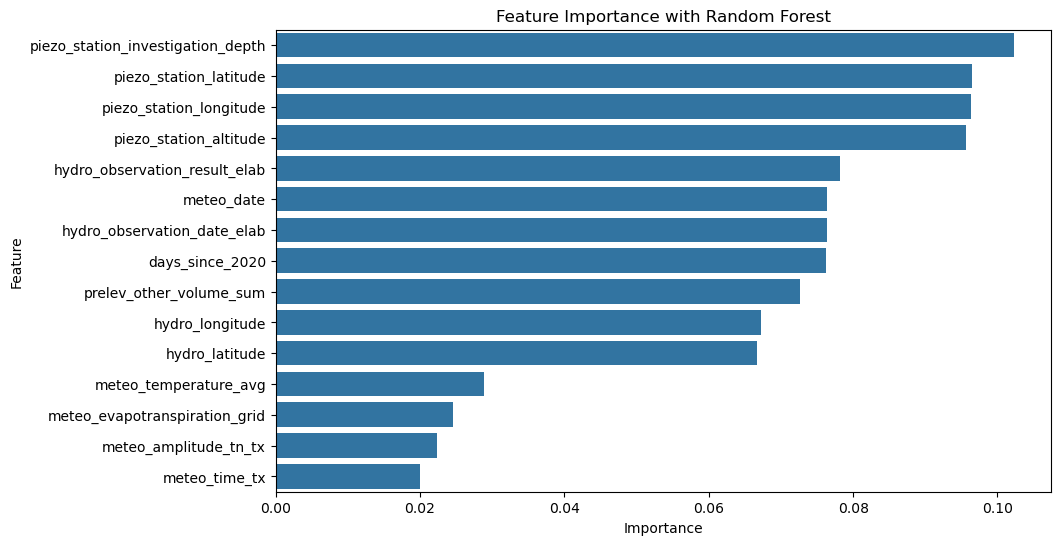

F1 Score: 0.9440583466867754


In [13]:
var = "piezo_groundwater_level_category"

# 1. Separate explanatory variables (X) and the target variable (y)
X = df_clean.drop(columns=[var])
y = df_clean[var]

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Apply Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Display feature importance
importances = model.feature_importances_

# Create a DataFrame to display the feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by descending importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the results
print(feature_importance)

# 5. Visualize feature importance as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance with Random Forest')
plt.show()

# 6. Predict the target variable on the test set
y_pred = model.predict(X_test)

# 7. Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # For multi-class classification, weighted average
print(f'F1 Score: {f1}')

### Heat Map 1

Plotting the heatmap allows us to see the links between features. We will not keep 2 features that are highly correlated. 

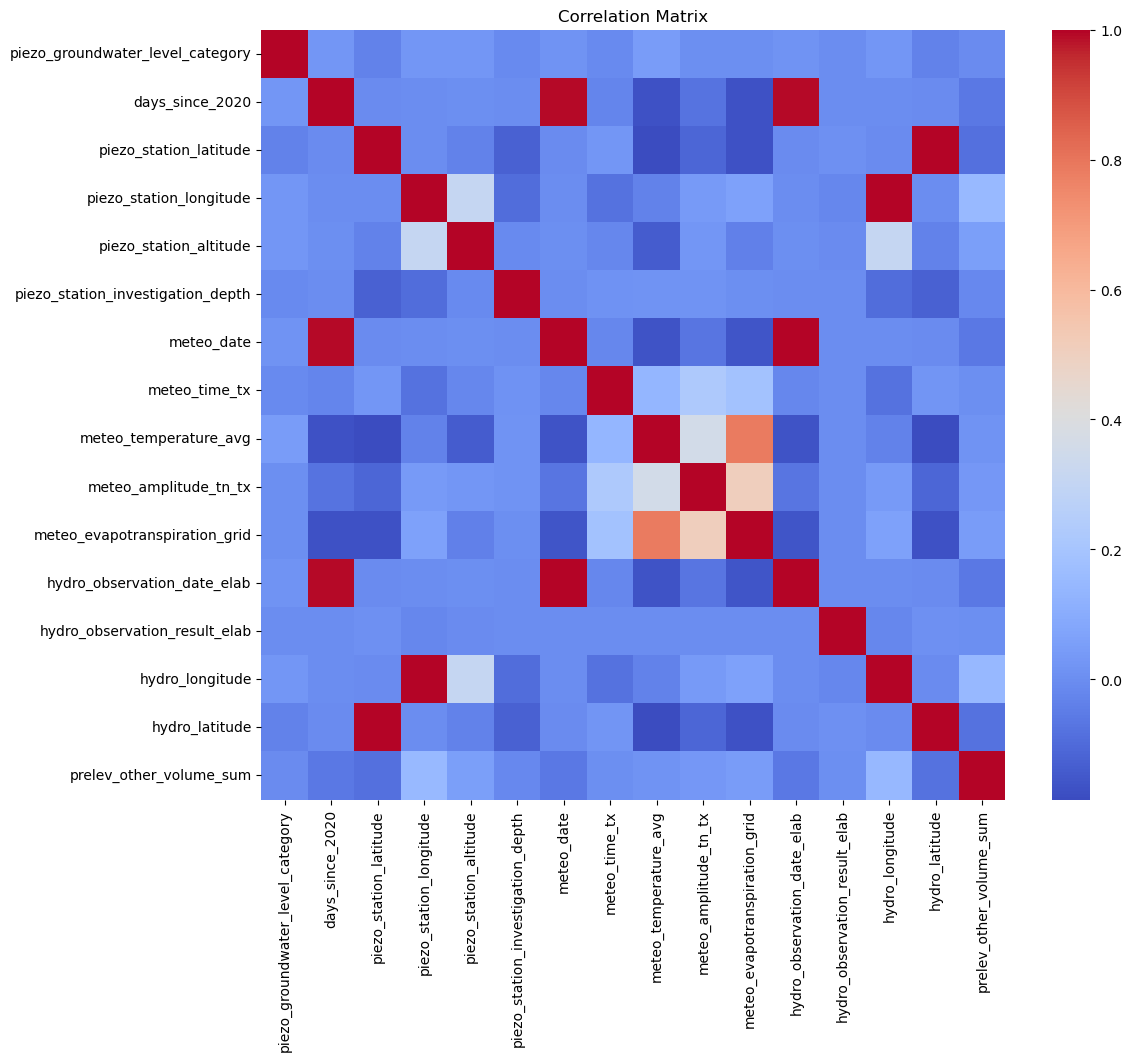

,piezo_groundwater_level_category,days_since_2020,piezo_station_latitude,piezo_station_longitude,piezo_station_altitude,piezo_station_investigation_depth,meteo_date,meteo_time_tx,meteo_temperature_avg,meteo_amplitude_tn_tx,meteo_evapotranspiration_grid,hydro_observation_date_elab,hydro_observation_result_elab,hydro_longitude,hydro_latitude,prelev_other_volume_sum
piezo_groundwater_level_category,1.000000,0.024985,-0.032598,0.028089,0.024386,-0.010049,0.015096,-0.012131,0.045523,0.001670,0.004673,0.015096,-0.001694,0.027801,-0.032691,-0.005259
days_since_2020,0.024985,1.000000,-0.004976,-0.000585,0.000800,-0.000143,0.995235,-0.023189,-0.167524,-0.077111,-0.166205,0.995235,-0.003183,-0.000424,-0.004674,-0.063578
piezo_station_latitude,-0.032598,-0.004976,1.000000,-0.003427,-0.035338,-0.126675,-0.004995,0.023605,-0.184716,-0.113552,-0.169708,-0.004995,0.005762,-0.006080,0.999338,-0.083256
piezo_station_longitude,0.028089,-0.000585,-0.003427,1.000000,0.309369,-0.095904,-0.000742,-0.079458,-0.034553,0.041925,0.061899,-0.000742,-0.019857,0.999520,-0.002815,0.148592
piezo_station_altitude,0.024386,0.000800,-0.035338,0.309369,1.000000,-0.012576,0.000823,-0.021747,-0.139756,0.026479,-0.038068,0.000823,-0.006943,0.308923,-0.034102,0.054183
piezo_station_investigation_depth,-0.010049,-0.000143,-0.126675,-0.095904,-0.012576,1.000000,-0.000108,0.013892,0.017285,0.015801,0.000736,-0.000108,-0.001343,-0.095880,-0.128559,-0.015888
meteo_date,0.015096,0.995235,-0.004995,-0.000742,0.000823,-0.000108,1.000000,-0.020893,-0.163647,-0.069130,-0.157655,1.000000,-0.002708,-0.000566,-0.004679,-0.062525
meteo_time_tx,-0.012131,-0.023189,0.023605,-0.079458,-0.021747,0.013892,-0.020893,1.000000,0.134676,0.226927,0.187743,-0.020893,0.000330,-0.080094,0.023241,0.003354
meteo_temperature_avg,0.045523,-0.167524,-0.184716,-0.034553,-0.139756,0.017285,-0.163647,0.134676,1.000000,0.357134,0.785817,-0.163647,-0.000199,-0.033926,-0.184714,0.018723
meteo_amplitude_tn_tx,0.001670,-0.077111,-0.113552,0.041925,0.026479,0.015801,-0.069130,0.226927,0.357134,1.000000,0.507579,-0.069130,-0.001566,0.041578,-0.113734,0.029779


In [15]:
def plot_correlation_matrix(dataframe, numerical_columns, figsize=(12, 10)):
    correlation_matrix = dataframe[numerical_columns].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()
    return correlation_matrix

plot_correlation_matrix(df_clean, keeped_features)

# Final Features

In [5]:
piezo_final_features = ['days_since_2020', 'piezo_station_latitude', 'piezo_station_longitude', 'piezo_station_altitude', 'piezo_station_investigation_depth']
weather_final_features = ['meteo_time_tx', 'meteo_temperature_avg', 'meteo_amplitude_tn_tx', 'meteo_evapotranspiration_grid']
hydro_final_features = ['hydro_observation_result_elab']
prelev_final_features = ['prelev_other_volume_sum']


final_features = ['piezo_groundwater_level_category'] + piezo_final_features + weather_final_features + hydro_final_features + prelev_final_features


In [6]:
df_final = df[final_features]

# Encode categorical variables using LabelEncoder
le = LabelEncoder()
for col in df_final.select_dtypes(include=['object']).columns:
    df_final[col] = le.fit_transform(df_final[col])

/tmp/ipykernel_14229/236327577.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[col] = le.fit_transform(df_final[col])


We plot the heatmap

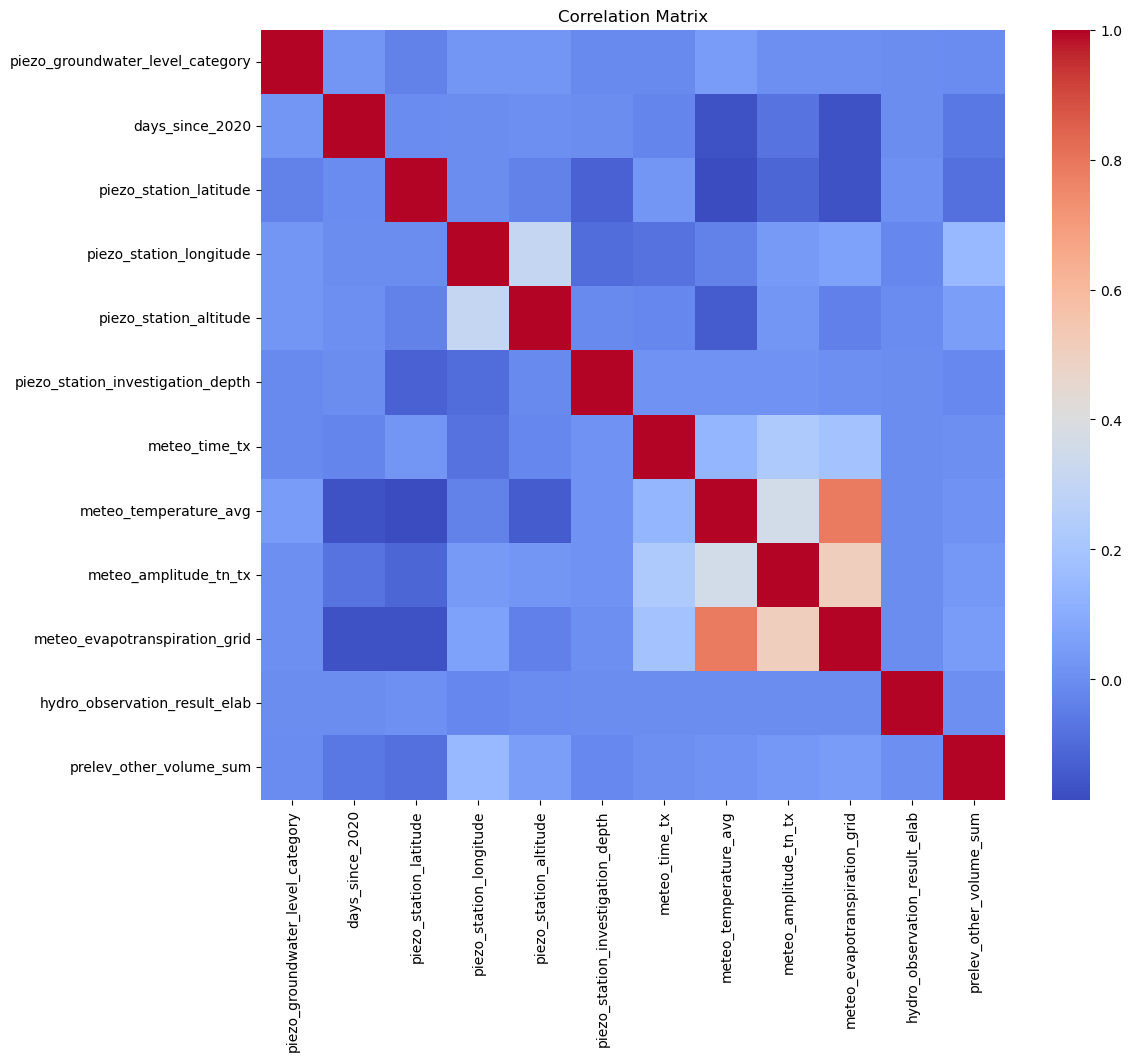

,piezo_groundwater_level_category,days_since_2020,piezo_station_latitude,piezo_station_longitude,piezo_station_altitude,piezo_station_investigation_depth,meteo_time_tx,meteo_temperature_avg,meteo_amplitude_tn_tx,meteo_evapotranspiration_grid,hydro_observation_result_elab,prelev_other_volume_sum
piezo_groundwater_level_category,1.000000,0.024985,-0.032598,0.028089,0.024386,-0.010049,-0.012131,0.045523,0.001670,0.004673,-0.001694,-0.005259
days_since_2020,0.024985,1.000000,-0.004976,-0.000585,0.000800,-0.000143,-0.023189,-0.167524,-0.077111,-0.166205,-0.003183,-0.063578
piezo_station_latitude,-0.032598,-0.004976,1.000000,-0.003427,-0.035338,-0.126675,0.023605,-0.184716,-0.113552,-0.169708,0.005762,-0.083256
piezo_station_longitude,0.028089,-0.000585,-0.003427,1.000000,0.309369,-0.095904,-0.079458,-0.034553,0.041925,0.061899,-0.019857,0.148592
piezo_station_altitude,0.024386,0.000800,-0.035338,0.309369,1.000000,-0.012576,-0.021747,-0.139756,0.026479,-0.038068,-0.006943,0.054183
piezo_station_investigation_depth,-0.010049,-0.000143,-0.126675,-0.095904,-0.012576,1.000000,0.013892,0.017285,0.015801,0.000736,-0.001343,-0.015888
meteo_time_tx,-0.012131,-0.023189,0.023605,-0.079458,-0.021747,0.013892,1.000000,0.134676,0.226927,0.187743,0.000330,0.003354
meteo_temperature_avg,0.045523,-0.167524,-0.184716,-0.034553,-0.139756,0.017285,0.134676,1.000000,0.357134,0.785817,-0.000199,0.018723
meteo_amplitude_tn_tx,0.001670,-0.077111,-0.113552,0.041925,0.026479,0.015801,0.226927,0.357134,1.000000,0.507579,-0.001566,0.029779
meteo_evapotranspiration_grid,0.004673,-0.166205,-0.169708,0.061899,-0.038068,0.000736,0.187743,0.785817,0.507579,1.000000,-0.000077,0.044223


In [23]:
def plot_correlation_matrix(dataframe, numerical_columns, figsize=(12, 10)):
    correlation_matrix = dataframe[numerical_columns].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()
    return correlation_matrix

plot_correlation_matrix(df_final, final_features)

                              Feature  Importance
0                     days_since_2020    0.189820
9       hydro_observation_result_elab    0.125037
1              piezo_station_latitude    0.112002
2             piezo_station_longitude    0.111029
4   piezo_station_investigation_depth    0.105557
3              piezo_station_altitude    0.103109
10            prelev_other_volume_sum    0.088188
6               meteo_temperature_avg    0.049839
8       meteo_evapotranspiration_grid    0.044121
7               meteo_amplitude_tn_tx    0.038002
5                       meteo_time_tx    0.033297


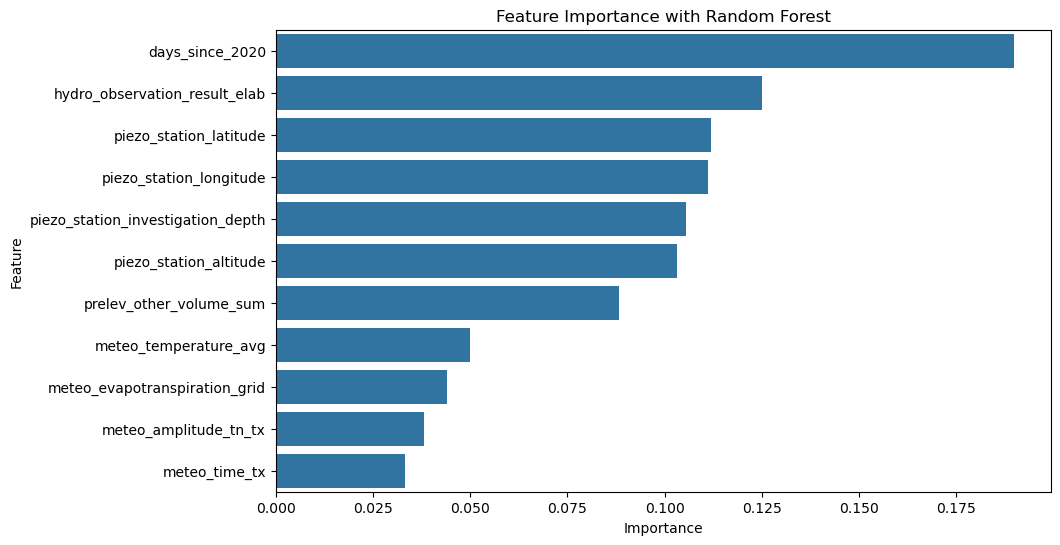

F1 Score: 0.9303193612964819


In [24]:
var = "piezo_groundwater_level_category"

# 1. Separate explanatory variables (X) and the target variable (y)
X = df_final.drop(columns=[var])
y = df_final[var]

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Apply Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Display feature importance
importances = model.feature_importances_

# Create a DataFrame to display the feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by descending importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the results
print(feature_importance)

# 5. Visualize feature importance as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance with Random Forest')
plt.show()

# 6. Predict the target variable on the test set
y_pred = model.predict(X_test)

# 7. Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # For multi-class classification, weighted average
print(f'F1 Score: {f1}')

# Saving the cleaned dataframe

In [7]:
df_final.to_csv('../X_test_Hi5_cleaned.csv')